In [25]:
import os
from hashlib import sha1
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import umap

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

# Can We Make Coherent Categories/Clusters of Different Food.com Recipe Names?

### Introduction to Food.com and our goals
Food.com is an online website that people share their recipes on. This results in a diverse mix of different dishes, desserts, and cuisines. We're wondering if we can find any sort of semantic "category" or groups that exist within the titles of these different recipes. Instead of working on all 180k+ recipe names in the Food.com Recipes and Interactions Kaggle dataset, however, for simplicity we are going to work just with a sample.

 We get this by taking recipes without names, with duplicate names, and with names that are too short (less than or equal to 5 characters long) out of our dataset, and selecting only the top recipes.

In [2]:
orig_recipes_df = pd.read_csv(
    "data/RAW_recipes.csv",
    engine="python", on_bad_lines='skip')
orig_recipes_df.shape

(6555, 12)

In [3]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(470, 12)

This results in a new dataset that has 470 columns (470 recipes) and 12 rows.

### Data Understanding and Exploratory Data Analysis (EDA) ###

Different features/aspects of the different recipes are as follows:

- name: name of the recipe
- id: Food.com recipe ID
- minutes: how long the recipe takes to make
- contributor_id: the ID of the person who uploaded the recipe
- submitted: the date that the recipe was submitted
- tags: the tags that the recipe falls under
- nutrition: nutrional information of the recipe
- n_steps: the total number of steps in the recipe
- steps: the actual steps of how to make the recipe
- description: the description of the recipe
- ingredients: the ingredients required to make the recipe
- n_ingredients: the number of ingrediants needed to make the recipe




We are going to just use the **name** feature, as our goal is to try to see if we can create distinct categories. (For the rest of this project, I'm going to just use the subset of the dataset we made earlier.)

We can try to gleam some more information about the data we have through some Exploratory Data Analysis. I did some other EDA outside of this report which helped me learn more about the names and the dataset in general. I made this word cloud to visualize some of the most common words in the names of the dataset:

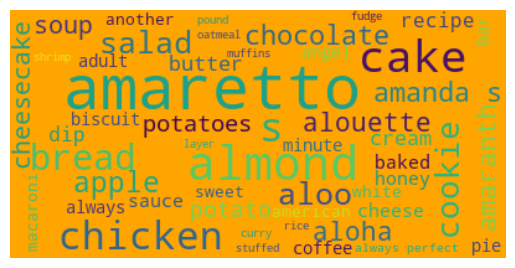

In [4]:
from wordcloud import WordCloud

names = recipes_df['name'].astype('string')

text = names.str.cat(sep = " ")
wordcloud = WordCloud(max_font_size = 50, max_words = 50, background_color = "orange").generate(text)

plt.plot()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

This word cloud shows us some of the most common words we've found in the recipe names. The larger words are ones that appear more frequently and more prominently in the photo, meaning that "amaretto" is the most popular in this dataset.

### Trying To Group The Recipe Names

In order to get a good representation of the names, we need to embed them. This means we need to encode the text into numberical vectors that will preserve the semantic meaning. We are going to use the embedded names for the rest of this project, as it brings a significantly better semantic interpretation of the words over a bag-of-words text model.

In [7]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = embedder.encode(names.tolist())
embeddings_df = pd.DataFrame(embeddings, index=recipes_df.index)

In [8]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
42,0.019592,-0.088336,0.072677,-0.034575,-0.048741,-0.049801,0.175334,-0.055191,0.020301,0.019828,...,0.063293,-0.067171,0.087499,-0.061550,0.039297,-0.050147,0.027708,0.056843,0.056151,-0.122506
101,-0.000567,-0.011825,0.073199,0.058176,0.031688,-0.015428,0.168134,0.000466,0.033078,-0.013923,...,-0.012926,-0.015949,0.031315,-0.059074,0.014143,-0.047270,0.007844,0.035501,0.076061,-0.078119
137,-0.036027,0.053818,-0.046677,0.015885,0.003456,-0.004948,-0.010464,0.053272,-0.039499,-0.006929,...,-0.027305,0.000574,0.025830,-0.028740,0.008241,-0.030950,0.038046,-0.029865,0.028311,0.065122
138,-0.066915,0.025988,-0.087689,-0.006847,-0.012861,0.049035,0.035351,0.124966,-0.011697,-0.050179,...,-0.042345,-0.005794,-0.031800,0.120664,-0.057335,-0.077068,0.001653,-0.048223,0.116455,0.021789
154,-0.000284,-0.030707,0.005041,-0.000297,-0.031228,0.023708,0.068304,-0.026955,0.015195,-0.022351,...,0.009068,0.028525,0.004598,-0.014333,0.083076,0.001411,0.001367,0.012990,-0.007127,-0.110756


Before we can get to actually clustering the names into groups, we need to figure out what the best model to use is, and what settings/hyperparameters to apply to those models. One way we can try this is by graphing out different visuals for different settings in a specific model, and seeing which settings perform best on each model. The way to decide this was to plot these all out and evaluate how tight the clusters appeared; how close similar colours were and how far apart different colours were. I did this behind the scenes, trying DBScan, hierarchical clustering, and KMeans clustering. I plotted these different model results out with this function I nabbed from my 6th CPSC 330 Homework Assignment:

In [26]:
def plot_umap_clusters(
    data,
    cluster_labels,
    raw_texts=None,
    show_labels=False,
    point_size=50,
    n_neighbors=15,
    title="UMAP Visualization",
    ignore_noise=False,
):
    """
    Perform dimensionality reduction using UMAP and visualize the resulting clusters.

    Parameters
    ----------
    data : np.ndarray
        Feature matrix to be reduced.
    cluster_labels : array-like
        Cluster label for each data point.
    raw_texts : list of str, optional
        Original texts corresponding to the data points (used when show_labels=True).
    show_labels : bool, default=False
        Whether to annotate points with text labels.
    point_size : int, default=50
        Size of the scatterplot points.
    n_neighbors : int, default=15
        Number of neighbors used in UMAP.
    title : str, default="UMAP Visualization"
        Title of the plot.
    ignore_noise : bool, default=False
        Whether to exclude points labeled as noise (-1).

    Returns
    -------
    None
    """
    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
    embedding = reducer.fit_transform(data)

    df = pd.DataFrame(embedding, columns=["dim1", "dim2"])
    df["cluster"] = cluster_labels

    if ignore_noise:
        df = df[df["cluster"] != -1]

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(title)

    scatter = ax.scatter(
        df["dim1"], df["dim2"],
        c=df["cluster"], cmap="tab20b", s=point_size
    )

    ax.legend(*scatter.legend_elements(), title="Clusters", loc="best")

    if show_labels and raw_texts is not None:
        for (x, y, text) in zip(df["dim1"], df["dim2"], raw_texts):
            ax.annotate(" ".join(text.split()[:10]), (x, y), fontsize=8)

    plt.show()

Most of the "better" clustering models had 3-5 clusters. From what I can tell, the clusters from the different models seem to consistently be in similar areas/groupings of the points. This tells me that all the models have some degree of "accuracy" to them, as they agree to some extent on similarities of specific points and suggest that there exists a stable structure. The DBSCAN was terrible (despite my best efforts in tuning... I definitely spent way too long tuning it), but everything else seemed to be generally pretty visually good (aside form lots of noise and stray points that I faced with every model). 

I've decided to use the K-Means model as my final model for this report on the clustering task because of its simplicity and interpretibility. To make sure I'm choosing the right settings (also known as hyperparamter) for this model, I charted out this elbow graph and sihlouette graph to help me pick the value of K:

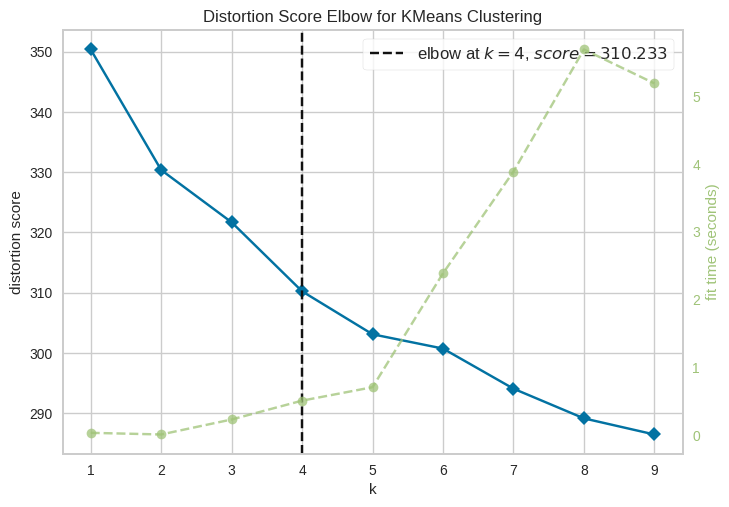

In [11]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model_elbow = KMeans(n_init='auto')
model_elbow._estimator_type = "clusterer"
visualizer = KElbowVisualizer(model_elbow, k=(1, 10))

visualizer.fit(embeddings)
visualizer.show();

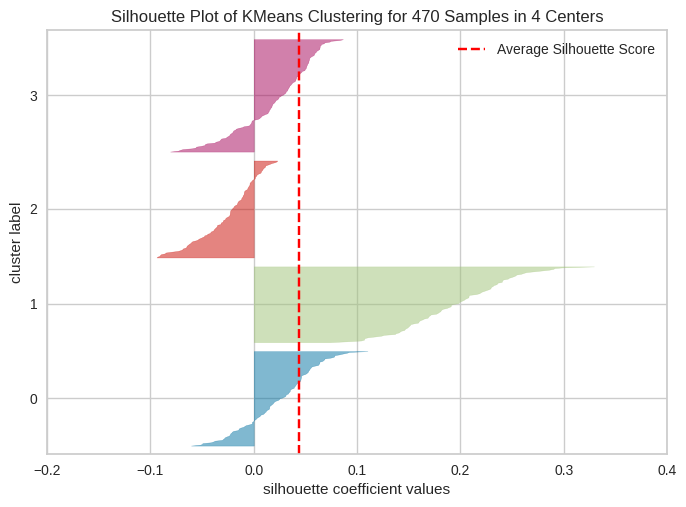

In [15]:
model_sil = KMeans(4, n_init='auto', random_state=42)
model_sil._estimator_type = "clusterer"
visualizer = SilhouetteVisualizer(model_sil, colors="yellowbrick")
visualizer.fit(embeddings)  # Fit the data to the visualizer
visualizer.show();

Even after trying different values (I tried K = 3, 4, 5), I just ended up using the point with the dashed vertical line on the elbow graph due to very negligible differences. In this case, the dashed vertical line is at 4, so I set the graph's hyperparameter to 4. The silhouette plot didn't look very nice in any of the other values, so I felt that 4 was reasonable enough.

This gives me the following clusters:


In [19]:
kmeans = KMeans(n_clusters=4, random_state = 43, n_init='auto')
kmeans_labels = kmeans.fit_predict(embeddings);

/opt/conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


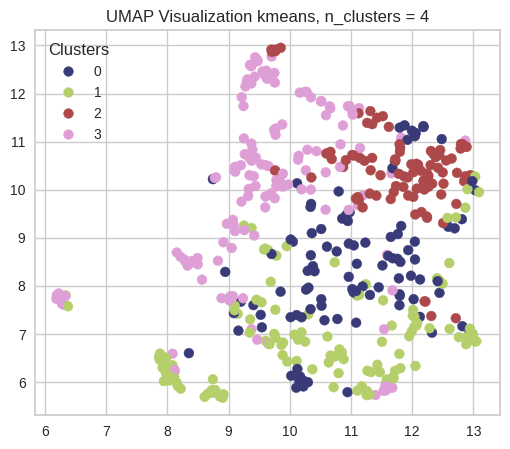

In [28]:
plot_umap_clusters(
        embeddings,
        kmeans_labels,
        title="UMAP Visualization kmeans, n_clusters = 4" ,
        ignore_noise=False,
    )

### Conclusion

We can see that the clusters in our resulting graph are not very clear. All the different colours are scattered within each other, and it does not look cohesive in any sense. The question was whether or not we can make coherent groups of the Food.com recipes, and we can tell from that graph that we are unable to. If we were able to, we would have been able to see clear groupings within the points on the plot, and the colours would not have this much bleed into each other. Therefore, we can conclude that we are unable to create cohesive groups across Food.com recipes.

A limitation to our process, however, is that we are only using a subset of the entire dataset, and we may have an unrepresentative sample. Maybe in the whole dataset, there would be tighter clusters and groups. Through this exploration and modeling, however, we know that this specific sample of the data would not result in a very cohesive grouping.